In [1]:
import os
import sys
sys.path.append('../') # add parent directory to path
from src.train.utils_train import calc_laplace_df_dr_ker
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import seaborn as sns
sns.set_style("darkgrid")
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.preprocessing import StandardScaler
from time import time
from tqdm import tqdm
from matplotlib import cm
DTYPE = 'float32'
full_ds_mat_path = '../data/ITER_like_equilibrium_dataset.mat'
sample_ds_mat_path = '../data/ITER_like_equilibrium_dataset_sample.mat'
N_SAMPLE_TRAIN = 500  #35000 # they will get multiplied by 2
N_SAMPLE_TEST = int(N_SAMPLE_TRAIN * 20 / 80) # 20% of the training data
# INTERP_METHOD = 'linear' # fast, but less accurate
INTERP_METHOD = 'quintic' # slow, but more accurate

if not os.path.exists('../data'): os.makedirs('../data') # create data directory 

2024-10-05 19:55:51.805941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 19:55:51.822326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 19:55:51.827422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 19:55:51.840456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 19:55:52.429838: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1728150953.624334   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728150953.668068   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728150953.668347   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
# # download datasets from gdrive, # uncomment if you want to download the dataset
# import gdown
# gdown.download(id="1-5KP7_OYIvDD_QXvIr5sDihVxZx1qJCN", output=full_ds_mat_path, quiet=False)
# gdown.download(id="1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue", output=sample_ds_mat_path, quiet=False)

In [3]:
# remove all files and dirs in the data directory except for full_ds_mat_path and sample_ds_mat_path
for file_or_dir in os.listdir('../data'):
    fn = os.path.join('../data', file_or_dir)
    if os.path.isfile(fn) and fn not in [full_ds_mat_path, sample_ds_mat_path]: os.remove(fn)
    elif os.path.isdir(fn): 
        for root, dirs, files in os.walk(fn, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(fn)
    else: print(f"Skipping {fn}")

Skipping ../data/ITER_like_equilibrium_dataset.mat
Skipping ../data/ITER_like_equilibrium_dataset_sample.mat


In [4]:
# Load dataset from mat file
mat_ds = io.loadmat(full_ds_mat_path)
DB_psi_pixel_test_ConvNet = mat_ds['DB_psi_pixel_test_ConvNet'][()].astype(DTYPE)
DB_meas_Bpickup_test_ConvNet = mat_ds['DB_meas_Bpickup_test_ConvNet'][()].astype(DTYPE)
DB_coils_curr_test_ConvNet = mat_ds['DB_coils_curr_test_ConvNet'][()].astype(DTYPE)
DB_p_test_ConvNet = mat_ds['DB_p_test_ConvNet'][()].astype(DTYPE)
RR_pixels = mat_ds['RR_pixels'][()].astype(DTYPE)
ZZ_pixels = mat_ds['ZZ_pixels'][()].astype(DTYPE)
DB_res_RHS_pixel_test_ConvNet = mat_ds['DB_res_RHS_pixel_test_ConvNet'][()].astype(DTYPE)
DB_separatrix_200_test_ConvNet = mat_ds['DB_separatrix_200_test_ConvNet'][()].astype(DTYPE)
DB_Jpla_pixel_test_ConvNet = mat_ds['DB_Jpla_pixel_test_ConvNet'][()].astype(DTYPE)
# define the dataset
Y_data = DB_psi_pixel_test_ConvNet
X_data = np.column_stack((DB_meas_Bpickup_test_ConvNet, DB_coils_curr_test_ConvNet)) #, DB_f_test_ConvNet, DB_p_test_ConvNet ))
N = Y_data.shape[0] # number of samples
# Save RR_pixels, ZZ_pixels
nr,nz = RR_pixels.shape
io.savemat(f'../data/data_geo_Dataset_NeuralOpt_super_res_{nr}x{nz}.mat',{'RR_pixels':RR_pixels,'ZZ_pixels':ZZ_pixels})   

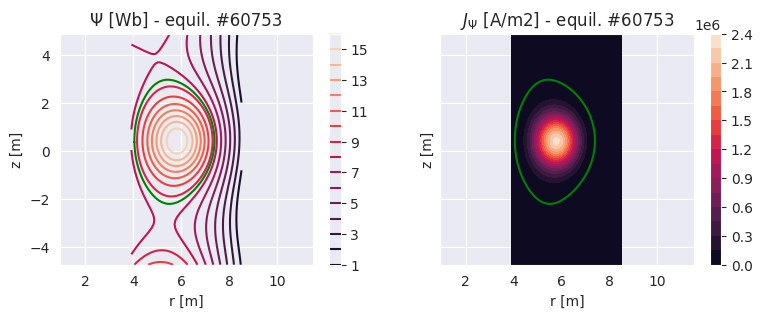

In [5]:
# plot dataset example
for i in range(0,1):
    ind_plot = np.random.randint(0,N,1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    img = axs[0].contour(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[0].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('Ψ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RR_pixels,ZZ_pixels,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_Ψ$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')

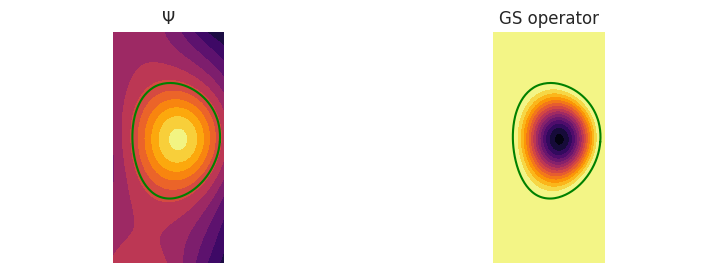

In [6]:
# plot Ψ and GS operator
cmap = cm.inferno
for i in range(0,1):
    ind_plot = np.random.randint(0,N,1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    rm, rM, zm, zM = RR_pixels.min(), RR_pixels.max(), ZZ_pixels.min(), ZZ_pixels.max()
    img = axs[0].contourf(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15,cmap=cmap)
    axs[0].plot( DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[0].set_xlim([rm,rM])
    axs[0].set_ylim([zm,zM])
    axs[0].axis('equal')
    axs[0].set_axis_off()
    axs[0].set_title('Ψ')
    qq = DB_res_RHS_pixel_test_ConvNet[ind_plot,:,:]
    img = axs[1].contourf(RR_pixels,ZZ_pixels,qq,15,cmap=cmap)
    axs[1].set_title('GS operator')
    axs[1].axis('equal')
    axs[1].set_xlim([rm,rM])
    axs[1].set_ylim([zm,zM])
    axs[1].axis('equal')
    axs[1].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[1].set_axis_off()
    # plt.savefig('./figures/equil_and_GSope', dpi=300)

In [7]:
# utils functions
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def sample_random_subgrids(RR_pixels,ZZ_pixels,nr=64,nz=64):
  rm, rM, zm, zM = RR_pixels.min(), RR_pixels.max(), ZZ_pixels.min(), ZZ_pixels.max()
  delta_r_min = .33*(rM-rm)
  delta_r_max = .75*(rM-rm)
  delta_z_min = .2*(zM-zm)
  delta_z_max = .75*(zM-zm)
  delta_r = np.random.uniform(delta_r_min,delta_r_max,1)
  r0 = np.random.uniform(rm,rm+delta_r_max-delta_r,1)
  delta_z = np.random.uniform(delta_z_min,delta_z_max,1)
  z0 = np.random.uniform(zm,zm+delta_z_max-delta_z,1)
  rr = np.linspace(r0,r0+delta_r,nr)
  zz = np.linspace(z0,z0+delta_z,nz)
  rr_grid, zz_grid = np.meshgrid(rr,zz,indexing='xy')
  return rr_grid, zz_grid

def get_box_from_grid(rr_grid, zz_grid):
  rm, rM, zm, zM = rr_grid.min(), rr_grid.max(), zz_grid.min(), zz_grid.max()
  return np.array([[rm,zm],[rM,zm],[rM,zM],[rm,zM],[rm,zm]])

def interp_fun(f, RR_pixels, ZZ_pixels, rr_grid, zz_grid, kind='quintic'):
  interp_func = RegularGridInterpolator((RR_pixels[0,:], ZZ_pixels[:,0]), f.T, method=kind)
  pts = np.column_stack((rr_grid.flatten(), zz_grid.flatten()))
  f_int = interp_func(pts).reshape(rr_grid.shape)
  return f_int

def def_grids_and_interp(f, rhs, RR_pixels, ZZ_pixels, nr=64, nz=64, kind='quintic'):
  rr_grid, zz_grid = sample_random_subgrids(RR_pixels,ZZ_pixels,nr,nz)
  f_grid = interp_fun(f,RR_pixels,ZZ_pixels,rr_grid, zz_grid,kind=kind)
  rhs_grid = interp_fun(rhs,RR_pixels,ZZ_pixels,rr_grid, zz_grid,kind=kind)
  return rr_grid, zz_grid, f_grid, rhs_grid

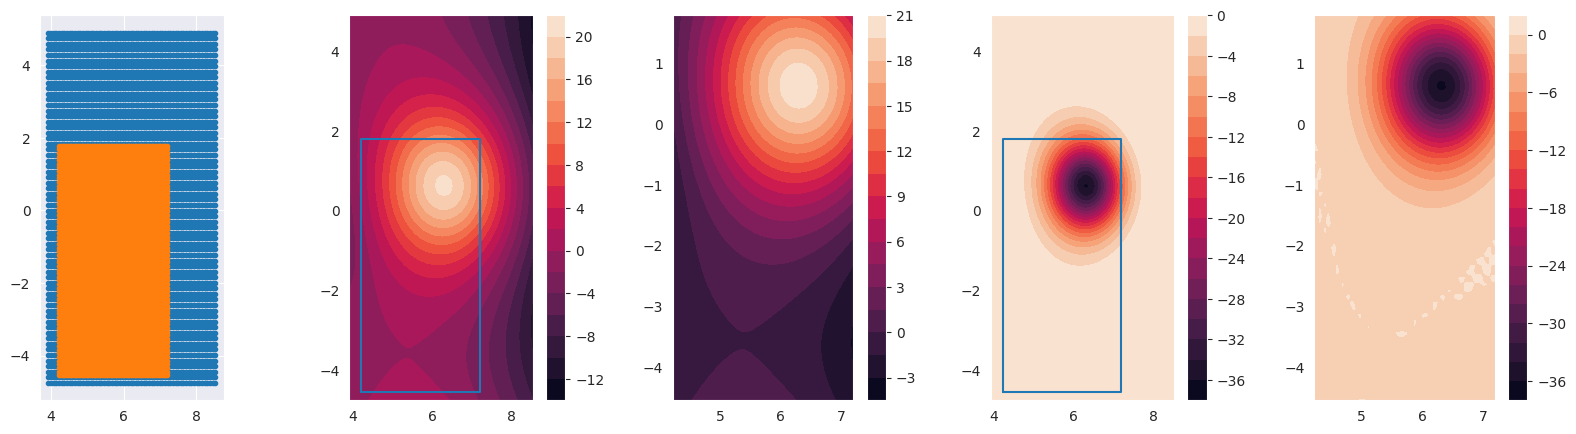

In [8]:
# test interpolation
idx = np.random.randint(0, Y_data.shape[0], 1)[0]
f, rhs = Y_data[idx,:,:], DB_res_RHS_pixel_test_ConvNet[idx,:,:]
rr_grid, zz_grid = sample_random_subgrids(RR_pixels,ZZ_pixels)
box = get_box_from_grid(rr_grid, zz_grid)
f_grid = interp_fun(Y_data[idx,:,:], RR_pixels, ZZ_pixels, rr_grid, zz_grid, kind=INTERP_METHOD)
rhs_grid = interp_fun(rhs, RR_pixels, ZZ_pixels, rr_grid, zz_grid, kind=INTERP_METHOD)

fig,ax = plt.subplots(1,5, figsize=(20,5))
ax[0].scatter(RR_pixels, ZZ_pixels, marker='.')
ax[0].scatter(rr_grid, zz_grid, marker='.')
ax[0].set_aspect('equal')

im1 = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].plot(box[:,0],box[:,1])
ax[1].set_aspect('equal')

im2 = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal')

im3 = ax[3].contourf(RR_pixels, ZZ_pixels, rhs, 20)
ax[3].set_aspect('equal')
ax[3].plot(box[:,0],box[:,1])

im4 = ax[4].contourf(rr_grid, zz_grid, rhs_grid, 20)
ax[4].set_aspect('equal')

plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
plt.colorbar(im3,ax=ax[3])
plt.colorbar(im4,ax=ax[4])

plt.show()

In [9]:
### train-test split 80-20
all_ids_shuffled = np.random.permutation(np.arange(N))
id_train, id_test = all_ids_shuffled[:int(N*0.8)], all_ids_shuffled[int(N*0.8):]
np.save('../data/id_train.npy', id_train)
np.save('../data/id_test.npy', id_test)
# ### Standardize input data
# scaler = StandardScaler()
# X_data = scaler.fit_transform(X_data)

In [10]:
'''
The full training dataset is ~80k equilibria. We select 35k equilibria on the full grid
and 35k equilibria to be resampled on randomly generated sub-grids. These two datasets 
are then put together ans shuffled.

_all_domain -> quantities related to the original grid
_super_res -> quantities related to random sub-grids

It would be nice to explore how the performance changes using data different from the 
aforementioned 35k/35k.
'''
# TODO: change this, generate random subgrids for all the data, not only for the training data, test
# data as well, and use much more subgrids
np.random.seed(42)
ind_all_domain = np.random.choice(id_train,N_SAMPLE_TRAIN)
ind_super_res = np.random.choice(id_train,N_SAMPLE_TRAIN)

n_all_domain = len(ind_all_domain)
n_super_res = len(ind_super_res)

print(f'{n_all_domain} equil on the original grid')
print(f'{n_super_res} equil on random sub-grids')

Y_train_all_domain = Y_data[ind_all_domain,:,:]
X_train_all_domain = X_data[ind_all_domain,:]
res_RHS_pixel_train_all_domain = DB_res_RHS_pixel_test_ConvNet[ind_all_domain,:,:]

y_test_all_domain = Y_data[id_test,:,:]
X_test_all_domain = X_data[id_test,:]
res_RHS_pixel_test_all_domain = DB_res_RHS_pixel_test_ConvNet[id_test,:,:]

f_for_super_res = Y_data[ind_super_res,:,:]
rhs_for_super_res = DB_res_RHS_pixel_test_ConvNet[ind_super_res,:,:]

X_train_super_res = X_data[ind_super_res,:]
y_train_super_res = np.zeros((n_super_res,64,64), dtype=DTYPE)
rhs_train_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
RR_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
ZZ_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)

500 equil on the original grid
500 equil on random sub-grids


In [11]:
# interpolate f and rhs on random sub-grids, NOTE: very slow if using 'quintic' method/kind
t_start = time()
for i in tqdm(range(f_for_super_res.shape[0]), miniters = 0):
    rr_grid, zz_grid, f_grid, rhs_grid = def_grids_and_interp(f_for_super_res[i,...],rhs_for_super_res[i,...],RR_pixels,ZZ_pixels, kind='quintic')
    RR_grid_super_res[i,:,:] = rr_grid
    ZZ_grid_super_res[i,:,:] = zz_grid
    y_train_super_res[i,:,:] = f_grid
    rhs_train_super_res[i,:,:] = rhs_grid
t_elapsed = time() - t_start
print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')
RR_grid_all_domain = np.tile(RR_pixels,(n_all_domain,1,1))
ZZ_grid_all_domain = np.tile(ZZ_pixels,(n_all_domain,1,1))

100%|██████████| 500/500 [00:16<00:00, 29.63it/s]

t_elapsed = 16.878742456436157, time_per_step = 0.03375748491287232


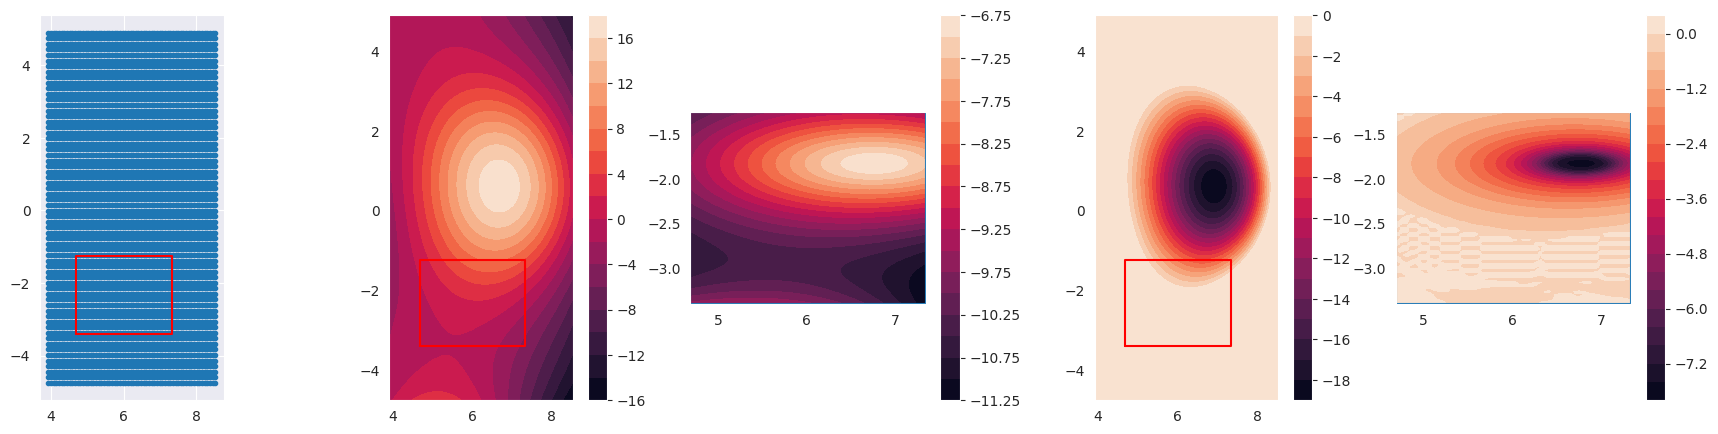

In [12]:
### Check re-sampled equils
idx = np.random.randint(0, len(y_train_super_res), 1)[0]

f = f_for_super_res[idx,:,:]
rhs = rhs_for_super_res[idx,:,:]
rr_grid = RR_grid_super_res[idx,:,:]
zz_grid = ZZ_grid_super_res[idx,:,:]
box = get_box_from_grid(rr_grid, zz_grid)

fig,ax = plt.subplots(1,5, figsize=(22,5))
ax[0].scatter(RR_pixels, ZZ_pixels, marker='.')
ax[0].plot(box[:,0],box[:,1],c='r')
ax[0].set_aspect('equal')

im = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].set_aspect('equal')
ax[1].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[1])
im = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])

im = ax[3].contourf(RR_pixels, ZZ_pixels, rhs, 20)
ax[3].set_aspect('equal')
ax[3].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[3])
im = ax[4].contourf(rr_grid, zz_grid, rhs_grid, 20)
ax[4].set_aspect('equal')
ax[4].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[4])
plt.show()

In [13]:
# compute kernels for the GS equation train
''' Compute kernels for GS Equation for the qeuils on the sub-grids (dr,dz is grid-dependent), 
otherwise we would have to compute them on the fly during each training step '''
y_train = np.row_stack([Y_train_all_domain,y_train_super_res])
X_train = np.row_stack([X_train_all_domain,X_train_super_res])
res_RHS_pixel_train = np.row_stack([res_RHS_pixel_train_all_domain,rhs_train_super_res])
RR_pixel_train = np.row_stack([RR_grid_all_domain,RR_grid_super_res])
ZZ_pixel_train = np.row_stack([ZZ_grid_all_domain,ZZ_grid_super_res])
print(X_train.shape, y_train.shape, res_RHS_pixel_train[:,1:-1,1:-1].shape, RR_pixel_train.shape, ZZ_pixel_train.shape)
Laplace_kernel = np.zeros((len(y_train),3,3),dtype=DTYPE)
Df_dr_kernel = np.zeros((len(y_train),3,3),dtype=DTYPE)
hrs, hzs = RR_pixel_train[:,1,2] - RR_pixel_train[:,1,1], ZZ_pixel_train[:,2,1] - ZZ_pixel_train[:,1,1]
for i, (hr, hz) in enumerate(tqdm(zip(hrs, hzs), total=len(hrs))):
    Laplace_kernel[i,:,:], Df_dr_kernel[i,:,:] = calc_laplace_df_dr_ker(hr, hz)
### Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train, res_RHS_pixel_train[:,1:-1,1:-1], RR_pixel_train, ZZ_pixel_train, Laplace_kernel, Df_dr_kernel)).shuffle(42)#.batch(batch_size=1024)
tf.data.Dataset.save(train_ds, '{}tf_Dataset_train_NeuralOpt_{}x{}_{}_samples.data'.format(outdir,nr,nz, X_train.shape[0]))

(1000, 201) (1000, 64, 64) (1000, 62, 62) (1000, 64, 64) (1000, 64, 64)


100%|██████████| 1000/1000 [00:00<00:00, 28361.16it/s]
I0000 00:00:1728150978.068652   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728150978.068896   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728150978.069069   22371 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728150978.153146   22371 cuda_ex

NameError: name 'outdir' is not defined

In [ ]:
# compute kernels for the GS equation test
y_test = y_test_all_domain
X_test = X_test_all_domain
res_RHS_pixel_test = res_RHS_pixel_test_all_domain
RR_pixel_test = np.tile(RR_pixels,(len(X_test),1,1))
ZZ_pixel_test = np.tile(ZZ_pixels,(len(X_test),1,1))
Laplace_kernel = np.zeros((len(y_test),3,3),dtype=DTYPE)
Df_dr_kernel = np.zeros((len(y_test),3,3),dtype=DTYPE)
hrs, hzs = RR_pixel_test[:,1,2] - RR_pixel_test[:,1,1], ZZ_pixel_test[:,2,1] - ZZ_pixel_test[:,1,1]
for i, (hr, hz) in enumerate(tqdm(zip(hrs, hzs), total=len(hrs))):
    Laplace_kernel[i,:,:], Df_dr_kernel[i,:,:] = calc_laplace_df_dr_ker(hr, hz)
# Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices(( X_test, y_test, res_RHS_pixel_test[:,1:-1,1:-1], RR_pixel_test, ZZ_pixel_test, Laplace_kernel, Df_dr_kernel)).shuffle(42)
tf.data.Dataset.save(train_ds, f'../data/tf_Dataset_test_NeuralOpt_{nr}x{nz}_{len(y_test)}_samples.data')